# Characterising KIC 10963065 (Rudy) with lightkurve

The star KIC 10963064 (hereafter Rudy) is a high signal-to-noise main sequence Kepler target. Its a perfect candidate to showcase `lightkurve`'s asteroseismology tools, as they are best suited to long *Kepler* timeseries and high signal-to-noise. This notebook will talk you through:

1. Searching for the data
2. Downloading and correcting the data
3. Stitching the data together into a single lightcurve
4. Creating a bespoke periodogram
5. Manipulating and plotting a periodogram
6. Calculating a rudimentary numax and deltanu
7. Plotting an echelle diagram
8. Calculating a rudimentary asteroseismic mass, radius and surface gravity

You can learn more and find tutorials at https://docs.lightkurve.org/ !

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import lightkurve as lk

datalist = lk.search_lightcurvefile('KIC10963065', cadence='short')
print(datalist)

SearchResult containing 27 data products.

 target_name            productFilename                        description              distance
------------- ------------------------------------ ------------------------------------ --------
kplr010963065 kplr010963065-2009259162342_slc.fits  Lightcurve Short Cadence (CSC) - Q2      0.0
kplr010963065 kplr010963065-2010111051353_slc.fits  Lightcurve Short Cadence (CSC) - Q5      0.0
kplr010963065 kplr010963065-2010140023957_slc.fits  Lightcurve Short Cadence (CSC) - Q5      0.0
kplr010963065 kplr010963065-2010174090439_slc.fits  Lightcurve Short Cadence (CSC) - Q5      0.0
kplr010963065 kplr010963065-2010203174610_slc.fits  Lightcurve Short Cadence (CSC) - Q6      0.0
kplr010963065 kplr010963065-2010234115140_slc.fits  Lightcurve Short Cadence (CSC) - Q6      0.0
kplr010963065 kplr010963065-2010265121752_slc.fits  Lightcurve Short Cadence (CSC) - Q6      0.0
kplr010963065 kplr010963065-2010296114515_slc.fits  Lightcurve Short Cadence (CSC) -

It looks like we've got plenty of quarters of data here. Let's download a couple of these back-to-back quarters. Lets do 5 through 7.

In [3]:
data = datalist[1:10].download_all()

`lightkurve` isn't meant to string together long time series in the first instance, so we're going to need a little extra work here to add all the data together.

Fortunately, lightcurves can be easily appended on top of one another. As we append on each quarter of data, we make sure to clean up each piece as it comes in by normalizing it, removing any NaNs and any outliers. Note that we are not using the `flatten()` function here. This can sometimes detrend the granluation background from our data.

In [4]:
lc = data[0].PDCSAP_FLUX.normalize().remove_nans().remove_outliers()
for d in data[1:]:
    lc = lc.append(d.PDCSAP_FLUX.normalize().remove_nans().remove_outliers())

Now let's check out our timeseries!

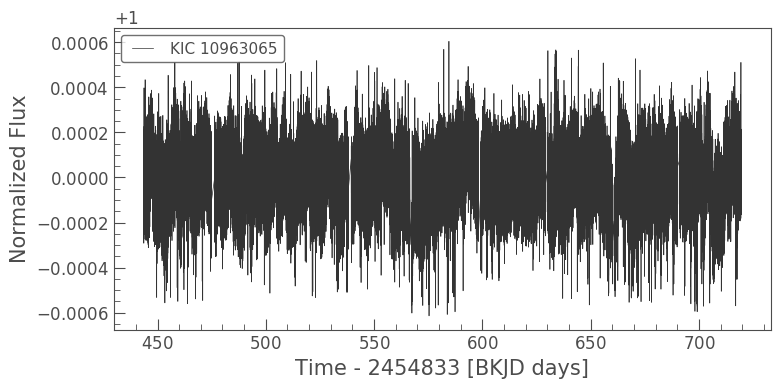

In [5]:
lc.plot()

Neat, we've got some data, and the transits are pretty clear! Now let's try and do some asteroseismology with it.

We'll convert this data to a lomb scargle periodogram. Because I'm a solar-like oscillators kind of asteroseismologist, I'm going to go ahead and set the normalization to 'psd'. This just means that the frequency units will be in $\mu Hz$, which I prefer, and that the power units will be in power density instead of amplitude. Give `normalization = 'amplitude'` a try too!

In [6]:
pg = lc.to_periodogram(method='lombscargle', normalization='psd')

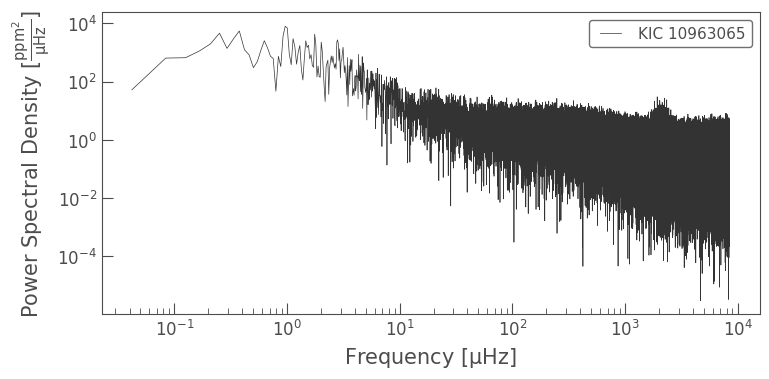

In [7]:
pg.plot(scale='log')

Looks like a power spectrum to me! There is a power excess around the $2000\, \mu \rm Hz$ mark, so lets get a closer look at that area. For this, I'll use the `minimum_frequency` and `maximum_frequency` keyword arguments. This truncates the frequency range evaluated when performing the LombScargle transformation.

For those of you who prefer to work in period instead of frequency, the `to_periodogram()` function has equivalent options to set `maximum_period` and `minimum_period`, or even pass in a custom grid of periods at which to compute the periodogram!

In [18]:
pg = lc.to_periodogram(method='lombscargle', normalization='psd',
                      minimum_frequency=1000, maximum_frequency=3000)

To get a nicer look at the data, we'll also plot a smoothed periodogram over the top. The `periodogram().smooth()` option stacks like most other `lightkurve` functions, making this an easy operation to do. The `ax` keyword argument in `lightkurve`'s `plot` function makes plotting multiple objects on the same graph easy too!

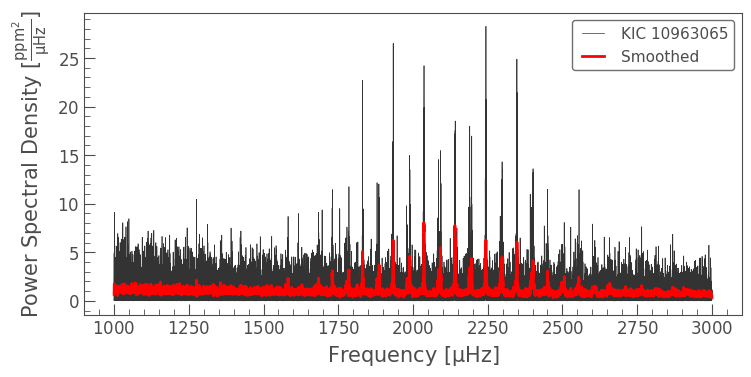

In [20]:
ax = pg.plot()
pg.smooth(method='boxkernel', filter_width=1.).plot(ax=ax, label='Smoothed', c='red', lw=2)

We could make a very rudimentary guess at $\nu_{\rm max}$ with that highest peak we see here. The `periodogram` object stores this info, lets have a look! 

In [10]:
pg.show_properties()

lightkurve.Periodogram properties:
      Attribute         Description     Units   
---------------------- -------------- ----------
                nterms              1           
              targetid       10963065           
          default_view      frequency           
                 label   KIC 10963065           
             ls_method           fast           
frequency_at_max_power      2244.0355        uHz
             max_power        27.2486 ppm2 / uHz
               nyquist      8496.4268        uHz
   period_at_max_power         0.0004    1 / uHz
             frequency array (71560,)        uHz
                period array (71560,)    1 / uHz
                 power array (71560,) ppm2 / uHz
                  meta <class 'dict'>           


The peak is located at $2141 \mu Hz$. 

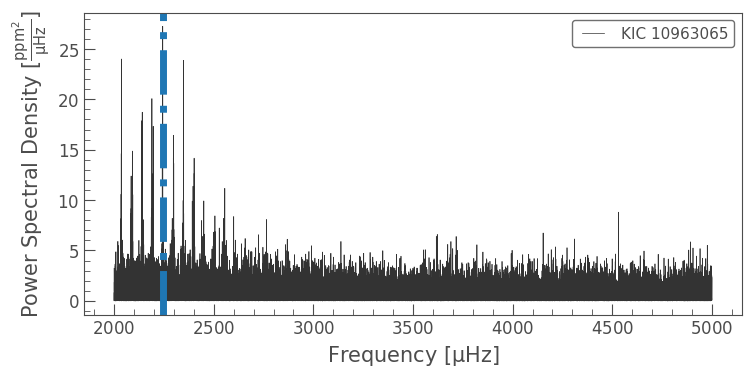

In [11]:
ax = pg.plot()
ax.axvline(pg.frequency_at_max_power.value, lw=5, ls='-.')

Thats not quite in the center of the mod envelope. Let's try and do better with `lightkurve`'s asteroseismology tools.

## Using lightkurve's asteroseismology tools

Before we can use the seismology tools, we want to flatten out the background so we get a Signal-to-noise spectrum. This is to make sure that low-frequency noise doesn't mess up our estimation process. The flattening will never be as good as a proper fit to the granulation background, but `lightkurve` is an investigation tool--- it makes our investigation a little easier!

This operation returns a `SNRPeriodogram`. Its the same as a regular `LombScarglePeriodogram` in every way, except the power is now a unitless signal-to-noise ratio.

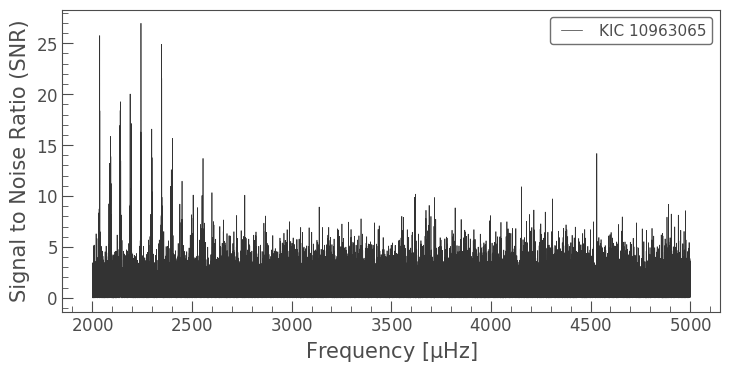

In [12]:
snr = pg.flatten()
snr.plot()

The seismology tools are all together in a seperate sub-module, handled by `SeismologyButler`. Let's call the butler and get to work on our seismology estimates!

In [13]:
butler = snr.to_seismology()
butler

SeismologyButler(ID: 10963065)

The periodogram object is stored as a property of the butler, so you can still call it like this:

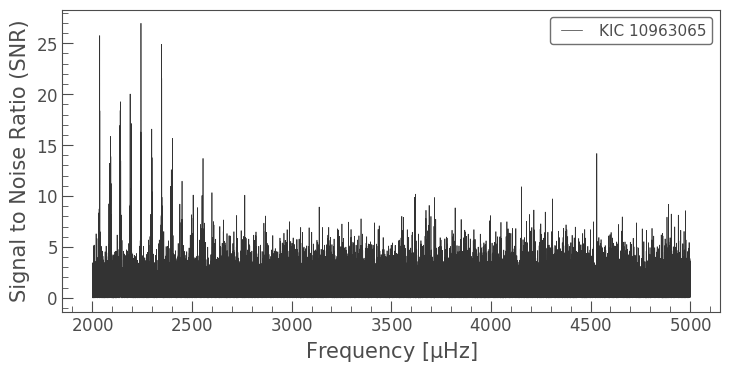

In [14]:
butler.periodogram.plot()

Alright, now let's get to business and try to estimate $\nu_{\rm max}$. The built-in method uses an Autocorrelation Function (following the techniques in Viani et al. 2019) to find where the power excess is highest in a shape approximately close to what we would expect for a solar-like oscillator's modes.

In [15]:
numax = butler.estimate_numax()
numax

<SeismologyQuantity 2125. uHz>

Personally, I'm always a little uncomfortable with a line of code giving me a value without knowing whats going on under the hood. Fortunately, we have the option to check out some diagnostic plots with the `plot_numax_diagnostics()` function. Lets have a look.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x135cf80b8>,
      dtype=object)

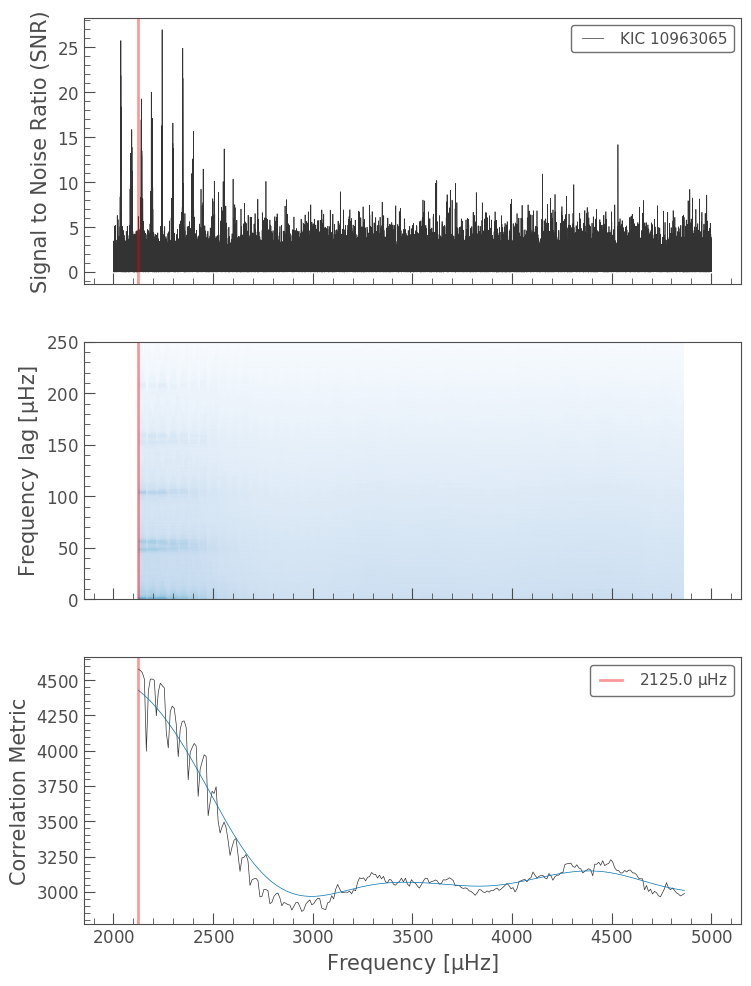

In [16]:
butler.diagnose_numax()

Looks like our 2D autocorrelation method is finding a value that doesn't look completely ridiculous. Neat! The next step is of course finding $\Delta\nu$. This also uses an autocorrelation method, but increases the width of the window so it covers the whole mode envelope.

Passing in the $\nu_{\rm max}$ autocorrelates a region approximately equivalent to the spread of the seismic mode envelope. Because this is where the p-modes reside, the resulting function should show neatly spaced peaks at a frequency lag equal to $\Delta\nu$. The SeismologyButler stores all its calculated values. You can pass a numax into this function, but ideally we'll want to have run `.estimate_numax()` first!

We estimate the deltanu first, and then have a look at the diagnostics.

In [17]:
deltanu = butler.estimate_deltanu()
butler.diagnose_deltanu()

ValueError: negative dimensions are not allowed

That looks broadly sensible! This method will never get something as accurate as a dedicated mode fitting effort, but it functions as a good first-look tool.

The real hallmark of a good $\Delta\nu$ is that it produces a nice echelle diagram. All `periodogram` classes have access to the `plot_echelle()` function, which only requires a $\Delta\nu$. If we pass it a $\nu_{\rm max}$ too, it just shows the area around the seismic mode envelope we care about!

In [ ]:
butler.plot_echelle(deltanu, numax)

If you (like me) prefer to smooth your echelle diagrams a little, you can make clever use of `lightkurve`'s 'sentence-like' coding structure.

NOTE: This doesn't work at the minute... we're working on making it elegant!

In [ ]:
smoothed_butler = butler
smoothed_butler.periodogram = smoothed_butler.periodogram.smooth(filter_width=2)
smoothed_butler.plot_echelle()

Thanks to the high signal-to-noise of these data, you can see the radial, dipole, and quadrupole modes clearly in the spectrum, including slight curvature in the mode frequencies. Not bad for 5 minutes in an iPython notebook!

Finally, let's try and find some stellar parameters using these data we've obtained.

## Using the seismic scaling relations with lightkurve

We've built the basic seismic scaling relations into `lightkurve` to make entry-level asteroseismology simpler. This comes with a few caveats of course--- it doesn't return uncertainties by default, and it is not equipped (yet) to deal with corrections to the scaling relations that are required to get accurate stellar parameters for more evolved stars.

Rudy is a main sequence star, so good enough for now! I know the temperature of this star to be $T_{\rm eff} = 6144\, K$. I had to look this up, unfortunately `lightkurve` can't do everything for us.

In [ ]:
Teff = 6144

In [ ]:
mass = butler.estimate_mass(Teff)
mass

We can do the same again for radius and surface gravity.

In [ ]:
radius = butler.estimate_radius(Teff)
radius

In [ ]:
logg = butler.estimate_logg(Teff)
logg

The best literature values for these are:

In [ ]:
print('Radius : {} vs {:.2f} Rsol'.format(1.210, radius.value))
print('Mass : {} vs {:.2f} Msol'.format(1.04, mass.value))
print('logg : {} vs {:.2f} dex'.format(4.29, logg.value))

That puts us pretty close!

I hope you enjoyed this little introduction to `lightkurve`'s suite of asteroseismology tools. We hope it functions as a good quick-look tool and as a useful hands-on introduction to the field of asteroseismology for new students and established academics alike!